In [10]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv')
def preprocess_headline(headline):
    headline = headline.lower()
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)  
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)  

    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)

    headline = re.sub(r'\s+', ' ', headline).strip()
    
    return headline

In [3]:
df['cleaned_headline'] = df['headline'].apply(preprocess_headline)
X = df['cleaned_headline']  
y = df['sentiment']  

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [6]:
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=5000, random_state=42)

In [7]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.545774647887324

Classification Report:
               precision    recall  f1-score   support

          -1       0.51      0.68      0.59       110
           0       0.72      0.40      0.52        84
           1       0.51      0.51      0.51        90

    accuracy                           0.55       284
   macro avg       0.58      0.53      0.54       284
weighted avg       0.57      0.55      0.54       284



In [13]:
print("Unique values in y_test:", y_test.unique())
print("Unique values in y_pred:", pd.Series(y_pred).unique())


Unique values in y_test: [ 1 -1  0]
Unique values in y_pred: [ 1  0 -1]


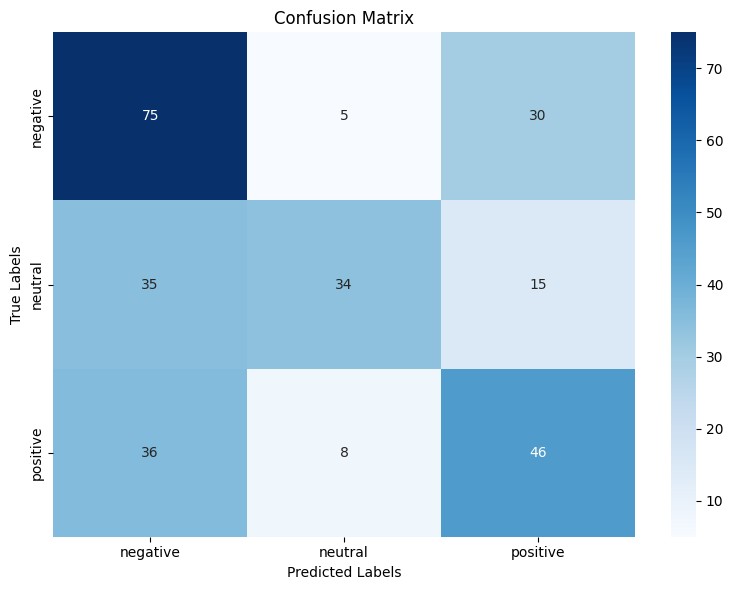

In [14]:

conf_matrix = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
